
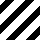
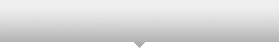
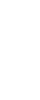
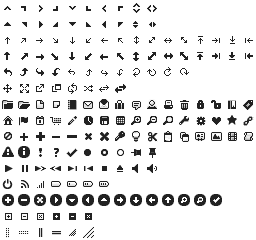
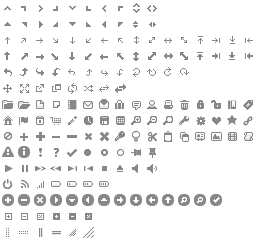
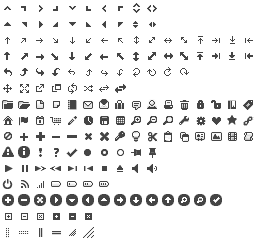
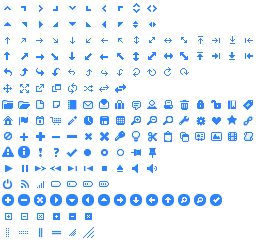
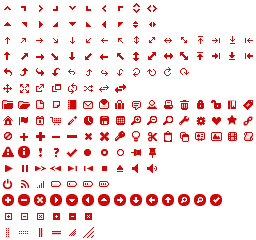
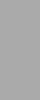
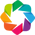
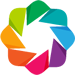
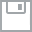
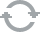
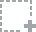
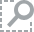
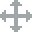
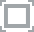
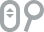

In [1]:
from bokeh.io import output_notebook, show
output_notebook()

In [2]:
import pandas as pd
import networkx as nx

from utils import GPG

In [3]:
gpg = GPG()
data = pd.DataFrame(gpg.to_dict())
data = data.fillna('')
len(data)

220

In [4]:
g = nx.Graph()

def add_node(row):
    key = row.keyid
    g.add_node(key)
    
def add_edge(row):
    key = row.keyid
    for connection in row.signedbykeys:
        g.add_edge(key, connection)

# Add nodes & edges to Graph and layout

In [5]:
data.apply(add_node, axis=1)
len(g.nodes())

220

In [6]:
data.apply(add_edge, axis=1)
len(g.edges())

225

In [7]:
pts = nx.spring_layout(g)

# Make data frames

In [8]:
start_keyids = []
end_keyids = []
xs = []
ys = []
for edge in g.edges():
    # Each edge is a tuple of start and end.
    start_id = edge[0]
    end_id = edge[1]
    start_keyids.append(start_id)
    end_keyids.append(end_id)
    
    # Get the xs and ys
    start_pt = pts[start_id]
    end_pt = pts[end_id]
    xs.append([start_pt[0], end_pt[0]])
    ys.append([start_pt[1], end_pt[1]])
edges = pd.DataFrame(dict(keyid=start_keyids, end_keyids=end_keyids, xs=xs, ys=ys))
len(edges)

225

In [9]:
points = pd.DataFrame(pts)
points = points.transpose()
points = points.reset_index()
points = points.rename(columns={
        0: 'x',
        1: 'y',
        'index': 'keyid'
    })

points = data.merge(points)
def lookup_line_index(point_row):
    keyid = point_row.keyid
    dir_1 = tuple(edges[edges.keyid == keyid].index.get_values())
    dir_2 = tuple(edges[edges.end_keyids == keyid].index.get_values())
    selected_edges = dir_1 + dir_2
    return selected_edges

points['line_indexes'] = points.apply(lookup_line_index, axis=1)
points.line_indexes = points.line_indexes.apply(lambda x: list(x))
points.uid = points.uid.str[0:60]
len(points)

220

In [10]:
points.head()

keyid signedby signedbykeys                        timestamp  \
0  ED18B68D16194553       []           []  Sat, 25 Jul 2015 23:56:19 -0000   
1  77EEDF0317F55690       []           []  Sat, 25 Jul 2015 23:56:19 -0000   
2  3D533EC06F80F701       []           []  Sat, 25 Jul 2015 23:56:19 -0000   
3  231CD035A9D1ACF9       []           []  Sat, 25 Jul 2015 23:56:19 -0000   
4  DE24858541A53190       []           []  Sat, 25 Jul 2015 23:56:19 -0000   

  uid         x         y line_indexes  
0      0.262829  0.617023          [0]  
1      0.495331  0.371764          [1]  
2      0.746342  0.707128          [2]  
3      0.491345  0.897368          [9]  
4      0.110171  0.412812          [4]

In [36]:
from bokeh.models import (
    Plot, 
    ColumnDataSource, 
    HoverTool, 
    TapTool, 
    Callback, 
    Circle, 
    MultiLine, 
    DataRange1d,
    BoxZoomTool,
    WheelZoomTool,
    ResetTool,
    ResizeTool,
    Text,
)

GRAY_50 = '#fafafa'
GRAY_100 = '#f5f5f5'
GRAY_200 = '#eeeeee'
GRAY_300 = '#e0e0e0'
GRAY_400 = '#bdbdbd'
GRAY_500 = '#9e9e9e'
GRAY_600 = '#757575'
GRAY_700 = '#616161'
GRAY_800 = '#424242'
GRAY_900 = '#212121'

CYAN_50 = '#e0f7fa'
CYAN_100 = '#b2ebf2'
CYAN_200 = '#80deea'
CYAN_300 = '#4dd0e1'
CYAN_400 = '#26c6da'
CYAN_500 = '#00bcd4'
CYAN_600 = '#00acc1'
CYAN_700 = '#0097a7'
CYAN_800 = '#00838f'
CYAN_900 = '#006064'

PINK_50 = '#fce4ec'
PINK_100 = '#f8bbd0'
PINK_200 = '#f48fb1'
PINK_300 = '#f06292'
PINK_400 = '#ec407a'
PINK_500 = '#e91e63'
PINK_600 = '#d81b60'
PINK_700 = '#c2185b'
PINK_800 = '#ad1457'
PINK_900 = '#880e4f'

inner_circle_source = ColumnDataSource(points)
text_source = ColumnDataSource(points)
outer_circle_source = ColumnDataSource(points)
line_source = ColumnDataSource(edges)

p = Plot(
    x_range=DataRange1d(), 
    y_range=DataRange1d(), 
    plot_height=600, 
    plot_width=800,
    background_fill=GRAY_900, 
    border_fill=GRAY_900,
    outline_line_color=None,
)

# Add lines - lowest level
 
line_props = dict(xs='xs', ys='ys', line_width=2, line_alpha=0.4)
nonselected_line = MultiLine(line_color=CYAN_900, **line_props)
selected_line = MultiLine(line_color=CYAN_50, **line_props)
p.add_glyph(
    line_source, 
    glyph=nonselected_line,
    nonselection_glyph=nonselected_line,
    selection_glyph=selected_line
)

# Add outer circle and tap

outer_circle_props = dict(x='x', y='y', size=15, line_color=None, fill_alpha=0.5)
nonselected_outer_circle = Circle(fill_color=CYAN_800, **outer_circle_props)
selected_outer_circle = Circle(fill_color=PINK_400, **outer_circle_props)
outer_cr = p.add_glyph(
    outer_circle_source, 
    glyph=nonselected_outer_circle, 
    nonselection_glyph=nonselected_outer_circle, 
    selection_glyph=selected_outer_circle
)
p.add_tools(TapTool(renderers=[outer_cr]))
tap_code = """
    var empty_selection,
        points_selection,
        lines_selection,
        points_selected,
        row_idx,
        signed_by,
        lines_indexes,
        new_points_selection;

    // What is the selected node?
    points_selection = outer_points.get('selected');
    points_selected = points_selection['1d'].indices;
    row_idx = points_selected[0]

    // Who signed the selected node?
    points_data = outer_points.get('data')
    signed_by = points_data['signedby']; // The signed_by_columns

    // Set the selection to the signees
    new_points_selection = points_selected.concat(signed_by[row_idx]);
    points_selection['1d'].indices = new_points_selection;
    outer_points.set('selected', points_selection);
"""
tap_callback = Callback(args=dict(outer_points=outer_circle_source), code=tap_code)
outer_circle_source.callback = tap_callback

# Add text
text_properties = dict(x=-0.2, y=-0.2, text='uid')
nonselected_text = Text(text_color=GRAY_900, **text_properties)  # Background color
selected_text = Text(text_color=CYAN_50, **text_properties)
p.add_glyph(
    text_source, 
    glyph=nonselected_text,
    nonselection_glyph=nonselected_text,
    selection_glyph=selected_text
)

# Add inner circle and hover

inner_circle_props = dict(x='x', y='y', size=10, fill_alpha=1)
nonselected_inner_circle = Circle(fill_color=CYAN_700, line_color=None, **inner_circle_props)
selected_inner_circle = Circle(fill_color=CYAN_200, line_color=CYAN_200, **inner_circle_props)
inner_cr = p.add_glyph(
    inner_circle_source, 
    glyph=nonselected_inner_circle, 
    nonselection_glyph=nonselected_inner_circle, 
    selection_glyph=selected_inner_circle
)

hover_code = """
    var empty_selection,
        points_selection,
        lines_selection,
        text_selection,
        points_selected,
        row_idx,
        signed_by,
        lines_indexes,
        new_points_selection;
    
        empty_selection = {
            '0d': {'flag': false, 'indices': []},
            '1d': {'indices': []},
            '2d': {'indices': []}
        };

    // What is the selected node?
    points_selection = cb_data['index'];
    lines_selection = lines.get('selected');
    text_selection = text.get('selected');
    
    if (points_selection['1d'].indices.length > 0) {
        points_selected = points_selection['1d'].indices;
                
        // Highlight the node text
        text_selection['1d'].indices = points_selected;
        text.set('selected', text_selection);
        
        row_idx = points_selected[0]

        // Who signed the selected node?
        points_data = points.get('data')
        signed_by = points_data['signedby']; // The signed_by_columns
        lines_indexes = points_data['line_indexes'];  // The line_indexes column

        // Set the selection to the signees
        new_points_selection = points_selected.concat(signed_by[row_idx]);
        points_selection['1d'].indices = new_points_selection;
        points.set('selected', points_selection);

        // Highlight the lines connected to selected_node
        lines_selection['1d'].indices = lines_indexes[row_idx];
        lines.set('selected', lines_selection);
    
    } else {
        points.set('selected', points_selection);
        lines.set('selected', empty_selection);
        text.set('selected', text_selection);
    }
"""
hover_callback = Callback(args=dict(points=inner_circle_source, lines=line_source, text=text_source), code=hover_code)
p.add_tools(HoverTool(tooltips=None, renderers=[inner_cr], callback=hover_callback))

#p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool(), ResizeTool())

show(p)